In [6]:
# importing required libraries
import pandas as pd
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
import re
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import string
import nltk
import warnings 
warnings.filterwarnings("ignore", category=DeprecationWarning)

%matplotlib inline

In [7]:
# read the dataset
data = pd.read_csv('twitter_sentiments.csv')
# view the top rows
data.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [8]:
# Describing the dataset
data.describe

<bound method NDFrame.describe of           id  label                                              tweet
0          1      0   @user when a father is dysfunctional and is s...
1          2      0  @user @user thanks for #lyft credit i can't us...
2          3      0                                bihday your majesty
3          4      0  #model   i love u take with u all the time in ...
4          5      0             factsguide: society now    #motivation
...      ...    ...                                                ...
31957  31958      0  ate @user isz that youuu?ðððððð...
31958  31959      0    to see nina turner on the airwaves trying to...
31959  31960      0  listening to sad songs on a monday morning otw...
31960  31961      1  @user #sikh #temple vandalised in in #calgary,...
31961  31962      0                   thank you @user for you follow  

[31962 rows x 3 columns]>

In [9]:
# train test split(80-20)
train, test = train_test_split(data, test_size = 0.2, stratify = data['label'], random_state=21)

# get the shape of train and test split.
train.shape, test.shape
## >> ((25569, 3), (6393, 3))

((25569, 3), (6393, 3))

Text PreProcessing and Cleaning

Data Inspection

Let's check out a few non racist/sexist tweets.

In [10]:
data['label'] 

0        0
1        0
2        0
3        0
4        0
        ..
31957    0
31958    0
31959    0
31960    1
31961    0
Name: label, Length: 31962, dtype: int64

In [11]:
train[train['label'] == 0].head(10)

,id,label,tweet
11221,11222,0,i am trusting. #i_am #positive #affirmation
8977,8978,0,trump vs clinton...smdh...america really is a ...
26800,26801,0,my ð&amp;ð go out 2the victims &amp;fami...
28522,28523,0,#rainbowrowell bull up: you will dominate yo...
5811,5812,0,@user @user just ordered two spf15 with bronz...
20639,20640,0,big smileðâï¸ð #blea #smile #school
15022,15023,0,48% of workers say they are very at work. mo...
6007,6008,0,@user gother my ticket to edge-lit quad derby...
12737,12738,0,alice))) #doggy #my #petstagram #instapets #pe...
23191,23192,0,"@user please, ow do i remove myself from annoy..."


Now check out a few racist/sexist tweets.

In [12]:
train[train['label'] == 1].head(10)

,id,label,tweet
22779,22780,1,#people aren't protesting #trump because a #re...
26239,26240,1,@user #allahsoil when the market crashed in ma...
4364,4365,1,@user 2017 â make fakequity great(er) again ...
8795,8796,1,#microsoft #twitterbot turns into a raging sex...
5088,5089,1,@user stop perpetuating false racism and lefti...
2293,2294,1,@user @user yes disgusting and hateful #trumps...
14325,14326,1,@user i'm constantly let down by the lack of f...
30163,30164,1,can math help defeat ? #math #literacy #adulte...
7583,7584,1,@user how does it feel to be most hated potus ...
22335,22336,1,"joy to the world, instead of #terrorism, #hate..."


Let's have a glimpse at label-distribution in the train dataset.

In [13]:
#0 - non racist/sexist tweet
#1 - racist/sexist tweet
train["label"].value_counts()

0    23775
1     1794
Name: label, dtype: int64

In the train dataset, we have 1794 (~7%)tweets labelled as racist/sexist and 23775(93%) tweets labeled as non racist/sexist. So, it is an imbalanced classification challenge.

Now we will check the distribution of length of the tweets, in terms of words, in both train and test data.

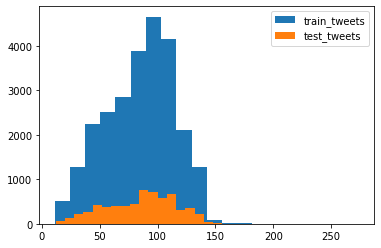

In [14]:
length_train = train['tweet'].str.len()
length_test = test['tweet'].str.len()

plt.hist(length_train, bins=20, label="train_tweets")
plt.hist(length_test, bins=20, label="test_tweets")
plt.legend()
plt.show()


Data Cleaning

In [15]:
# combinig the test and train dataset
data = train.append(test, ignore_index=True)
data.shape

(31962, 3)

In [16]:
#user-defined function to remove unwanted text patterns from the tweets.
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)
        
    return input_txt

1. Removing Twitter Handles (@user)

In [17]:
data['tidy_tweet'] = np.vectorize(remove_pattern)(data['tweet'], "@[\w]*") 
data.head()

,id,label,tweet,tidy_tweet
0,11222,0,i am trusting. #i_am #positive #affirmation,i am trusting. #i_am #positive #affirmation
1,8978,0,trump vs clinton...smdh...america really is a ...,trump vs clinton...smdh...america really is a ...
2,26801,0,my ð&amp;ð go out 2the victims &amp;fami...,my ð&amp;ð go out 2the victims &amp;fami...
3,28523,0,#rainbowrowell bull up: you will dominate yo...,#rainbowrowell bull up: you will dominate yo...
4,5812,0,@user @user just ordered two spf15 with bronz...,just ordered two spf15 with bronzes and lip...


2. Removing Punctuations, Numbers, and Special Characters

In [18]:
# we do not remove the hashtag
data['tidy_tweet'] = data['tidy_tweet'].str.replace("[^a-zA-Z#]", " ")
data.head(10)

,id,label,tweet,tidy_tweet
0,11222,0,i am trusting. #i_am #positive #affirmation,i am trusting #i am #positive #affirmation
1,8978,0,trump vs clinton...smdh...america really is a ...,trump vs clinton smdh america really is a ...
2,26801,0,my ð&amp;ð go out 2the victims &amp;fami...,my amp go out the victims amp fami...
3,28523,0,#rainbowrowell bull up: you will dominate yo...,#rainbowrowell bull up you will dominate yo...
4,5812,0,@user @user just ordered two spf15 with bronz...,just ordered two spf with bronzes and lip...
5,20640,0,big smileðâï¸ð #blea #smile #school,big smile #blea #smile #school
6,15023,0,48% of workers say they are very at work. mo...,of workers say they are very at work mo...
7,6008,0,@user gother my ticket to edge-lit quad derby...,gother my ticket to edge lit quad derby a...
8,12738,0,alice))) #doggy #my #petstagram #instapets #pe...,alice #doggy #my #petstagram #instapets #pe...
9,23192,0,"@user please, ow do i remove myself from annoy...",please ow do i remove myself from annoying g...


3. Removing Short Words

In [19]:
# removing the words having lenght shorter than 3
data['tidy_tweet'] = data['tidy_tweet'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))
data.head(10)

,id,label,tweet,tidy_tweet
0,11222,0,i am trusting. #i_am #positive #affirmation,trusting #positive #affirmation
1,8978,0,trump vs clinton...smdh...america really is a ...,trump clinton smdh america really nation idiots
2,26801,0,my ð&amp;ð go out 2the victims &amp;fami...,victims families this horrible attack orlando ...
3,28523,0,#rainbowrowell bull up: you will dominate yo...,#rainbowrowell bull will dominate your bull wi...
4,5812,0,@user @user just ordered two spf15 with bronz...,just ordered with bronzes balm #australiangold
5,20640,0,big smileðâï¸ð #blea #smile #school,smile #blea #smile #school
6,15023,0,48% of workers say they are very at work. mo...,workers they very work more #workforce insights
7,6008,0,@user gother my ticket to edge-lit quad derby...,gother ticket edge quad derby anyone advice ot...
8,12738,0,alice))) #doggy #my #petstagram #instapets #pe...,alice #doggy #petstagram #instapets #pet #pets...
9,23192,0,"@user please, ow do i remove myself from annoy...",please remove myself from annoying groups face...


4. Text Normalization

Text normalization is the process of transforming a text into a canonical (standard) form. For example, the word “gooood” and “gud” can be transformed to “good”, its canonical form. Another example is mapping of near identical words such as “stopwords”, “stop-words” and “stop words” to just “stopwords”.


Here we will use nltk's PorterStemmer() function to normalize the tweets. But before that we will have to tokenize the tweets. Tokens are individual terms or words, and tokenization is the process of splitting a string of text into tokens.

In [20]:
tokenized_tweet = data['tidy_tweet'].apply(lambda x: x.split()) # tokenizing

In [21]:
tokenized_tweet.head()

0                  [trusting, #positive, #affirmation]
1    [trump, clinton, smdh, america, really, nation...
2    [victims, families, this, horrible, attack, or...
3    [#rainbowrowell, bull, will, dominate, your, b...
4    [just, ordered, with, bronzes, balm, #australi...
Name: tidy_tweet, dtype: object

Now we can normalize the tokenized tweets.

In [22]:
from nltk.stem.porter import *
stemmer = PorterStemmer()

tokenized_tweet = tokenized_tweet.apply(lambda x: [stemmer.stem(i) for i in x]) # stemming
#tokenized_tweet.head()

Now let’s stitch these tokens back together.

In [23]:
for i in range(len(tokenized_tweet)):
    tokenized_tweet[i] = ' '.join(tokenized_tweet[i])
    
data['tidy_tweet'] = tokenized_tweet
#data['tidy_tweet'].head()

Story Generation and Visualization from Tweets

A) Understanding the common words used in the tweets: WordCloud

Now I want to see how well the given sentiments are distributed across the train dataset. One way to accomplish this task is by understanding the common words by plotting wordclouds.

A wordcloud is a visualization wherein the most frequent words appear in large size and the less frequent words appear in smaller sizes.

Let’s visualize all the words our data using the wordcloud plot.

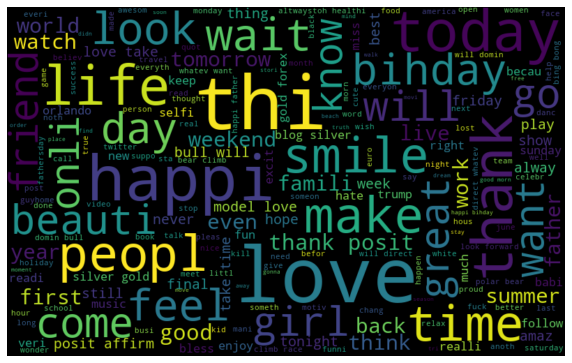

In [24]:
all_words = ' '.join([text for text in data['tidy_tweet']])
from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()



We can see most of the words are positive or neutral. Words like love, great, friend, life are the most frequent ones. It doesn’t give us any idea about the words associated with the racist/sexist tweets. Hence, we will plot separate wordclouds for both the classes (racist/sexist or not) in our train data.


B) Words in non racist/sexist tweets

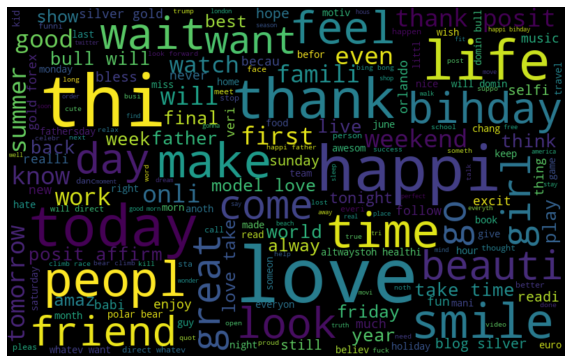

In [25]:
normal_words =' '.join([text for text in data['tidy_tweet'][data['label'] == 0]])

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(normal_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()


Most of the frequent words are compatible with the sentiment, i.e, non-racist/sexists tweets. Similarly, we will plot the word cloud for the other sentiment. Expect to see negative, racist, and sexist terms.

C) Racist/Sexist Tweets

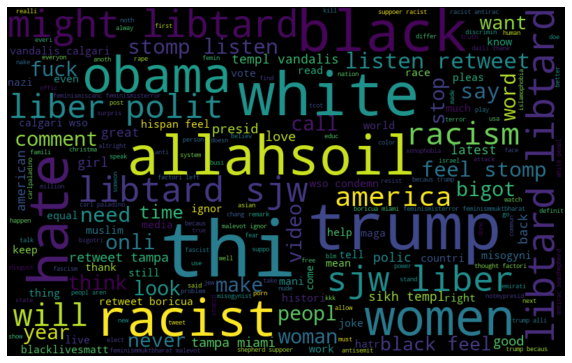

In [26]:
negative_words = ' '.join([text for text in data['tidy_tweet'][data['label'] == 1]])
wordcloud = WordCloud(width=800, height=500,
random_state=21, max_font_size=110).generate(negative_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

As we can clearly see, most of the words have negative connotations. So, it seems we have a pretty good text data to work on. Next we will the hashtags/trends in our twitter data.


D) Understanding the impact of Hashtags on tweets sentiment

People use the hashtag symbol (#) before a relevant keyword or phrase in their Tweet to categorize those Tweets and help them show more easily in Twitter search. Clicking or tapping on a hashtagged word in any message shows you other Tweets that include that hashtag.

In [27]:
# function to collect hashtags
def hashtag_extract(x):
    hashtags = []
    # Loop over the words in the tweet
    for i in x:
        ht = re.findall(r"#(\w+)", i)
        hashtags.append(ht)

    return hashtags

In [28]:
# extracting hashtags from non racist/sexist tweets

HT_regular = hashtag_extract(data['tidy_tweet'][data['label'] == 0])

# extracting hashtags from racist/sexist tweets
HT_negative = hashtag_extract(data['tidy_tweet'][data['label'] == 1])

# unnesting list
HT_regular = sum(HT_regular,[])
HT_negative = sum(HT_negative,[])

Now that we have prepared our lists of hashtags for both the sentiments, we can plot the top 'n' hashtags. So, first let’s check the hashtags in the non-racist/sexist tweets.

Non-Racist/Sexist Tweets

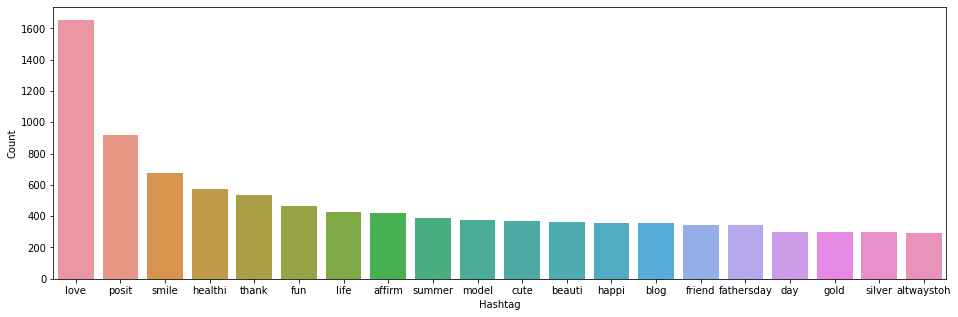

In [29]:
a = nltk.FreqDist(HT_regular)
d = pd.DataFrame({'Hashtag': list(a.keys()),
                  'Count': list(a.values())})

# selecting top 20 most frequent hashtags     
d = d.nlargest(columns="Count", n = 20) 
plt.figure(figsize=(16,5))
ax = sns.barplot(data=d, x= "Hashtag", y = "Count")
ax.set(ylabel = 'Count')
plt.show()


All these hashtags are positive and it makes sense. I am expecting negative terms in the plot of the second list. Let’s check the most frequent hashtags appearing in the racist/sexist tweets.

Racist/Sexist Tweets

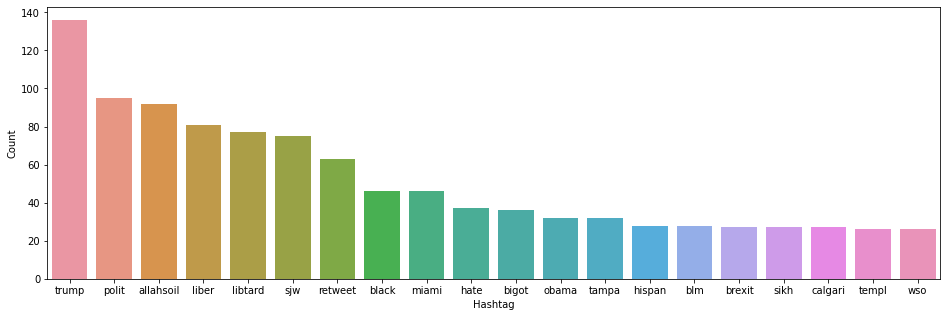

In [30]:
b = nltk.FreqDist(HT_negative)
e = pd.DataFrame({'Hashtag': list(b.keys()), 'Count': list(b.values())})

# selecting top 20 most frequent hashtags
e = e.nlargest(columns="Count", n = 20)   
plt.figure(figsize=(16,5))
ax = sns.barplot(data=e, x= "Hashtag", y = "Count")


As expected, most of the terms are negative with a few neutral terms as well. So, it’s not a bad idea to keep these hashtags in our data as they contain useful information. Next, we will try to extract features from the tokenized tweets.

Extracting Features from Cleaned Tweets

In [31]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import gensim

Bag-of-Words Features

In [32]:
# max_df:words coming more than 90 % of entire corpus are removed
# min_df: words coming in less than 2 documents or tweets are removed
bow_vectorizer = CountVectorizer(max_df=0.90, min_df=2, max_features=1000, stop_words='english')
bow = bow_vectorizer.fit_transform(data['tidy_tweet'])
bow.shape

(31962, 1000)

TF-IDF Features

In [33]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.90, min_df=2, max_features=1000, stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(data['tidy_tweet'])
tfidf.shape

(31962, 1000)

Word Embeddings
1. Word2Vec Embeddings

In [34]:
tokenized_tweet = data['tidy_tweet'].apply(lambda x: x.split()) # tokenizing

model_w2v = gensim.models.Word2Vec(
            tokenized_tweet,
            size=200, # desired no. of features/independent variables 
            window=5, # context window size
            min_count=2,
            sg = 1, # 1 for skip-gram model
            hs = 0,
            negative = 10, # for negative sampling
            workers= 2, # no.of cores
            seed = 34)

model_w2v.train(tokenized_tweet, total_examples= len(data['tidy_tweet']), epochs=20)

(4162307, 4904460)

In [35]:
model_w2v.wv.most_similar(positive="trump")

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('#delegaterevolt', 0.5900513529777527),
 ('quaint', 0.572819709777832),
 ('#dumptrump', 0.5686676502227783),
 ('unstabl', 0.5603540539741516),
 ('endors', 0.5584702491760254),
 ('unfit', 0.5564136505126953),
 ('whoa', 0.5518596768379211),
 ('commi', 0.5504060387611389),
 ('hillari', 0.549553394317627),
 ('capitalist', 0.5457431077957153)]

In [36]:
model_w2v['food']

array([-0.32505435, -0.35264382,  1.19308   , -0.33536193,  0.05234468,
        0.17895144, -0.18175827, -0.21554673, -0.34864277, -0.52284735,
        0.37795788,  0.22350341, -0.11809763, -0.33950436, -0.25497222,
       -0.36912704,  0.49310106, -0.01068915,  0.3233559 , -0.6516917 ,
        0.07243726, -0.37565595,  0.70217884, -0.347844  ,  0.10430821,
        0.25157654,  0.8833207 ,  0.18513896,  0.05183601, -0.05314334,
        0.39509726,  0.07982063,  0.23670666, -0.10021022, -0.15258463,
        0.38984182,  0.15094765, -0.01834944,  0.47163278,  0.54754937,
        0.4277981 , -0.3665926 , -0.5182671 , -0.18009154,  0.28301513,
        0.4353214 ,  0.3909214 ,  0.6625002 ,  0.16691086, -0.17032933,
       -0.10407436,  0.09729518,  0.09874991, -0.8756351 ,  0.15075642,
       -0.21342772,  0.17079571, -0.28499067, -0.5966461 ,  0.2530056 ,
        0.68826383,  0.17001824, -0.2831539 , -0.5241767 ,  0.35365087,
       -0.56571615,  0.51567173,  0.35986298,  0.38805872, -0.05

Preparing Vectors for Tweets

We will use the below function to create a vector for each tweet by taking the average of the vectors of the words present in the tweet.

In [37]:
def word_vector(tokens, size):
    vec = np.zeros(size).reshape((1, size))
    count = 0.
    for word in tokens:
        try:
            vec += model_w2v[word].reshape((1, size))
            count += 1.
        except KeyError: # handling the case where the token is not in vocabulary
                         
            continue
    if count != 0:
        vec /= count
    return vec

In [110]:
# creating a feature vector of of all tweets in our datset with dimensions 200
# each row represents the vector for that tweet
wordvec_arrays = np.zeros((len(tokenized_tweet), 200))

for i in range(len(tokenized_tweet)):
    wordvec_arrays[i,:] = word_vector(tokenized_tweet[i], 200)
    
wordvec_df = pd.DataFrame(wordvec_arrays)
wordvec_df.shape
xtrain_w2v , xtest_w2v = train_test_split(wordvec_df, test_size = 0.2, stratify = data['label'], random_state=21)
xtrain_w2v , xtest_w2v

(            0         1         2    ...       197       198       199
 11221 -0.005443  0.218135  0.047341  ... -0.008854 -0.083851  0.016643
 8962  -0.010188  0.201226 -0.112698  ...  0.257951 -0.845087  0.444020
 26806  0.031060  0.344778  0.099246  ... -0.029170 -0.252419  0.139825
 28521 -0.051114  0.209457  0.173815  ...  0.018647 -0.335996 -0.142171
 5826  -0.062330  0.117016 -0.102355  ... -0.216096 -0.283780  0.145198
 ...         ...       ...       ...  ...       ...       ...       ...
 28243 -0.324781 -0.118132  0.328454  ...  0.093266 -0.219979  0.378148
 13956 -0.091946  0.252605  0.176966  ... -0.142056 -0.444330  0.185445
 16424 -0.044514  0.172964  0.124432  ... -0.035723 -0.174101  0.130496
 7175  -0.022351  0.275199 -0.102648  ...  0.002347 -0.417744  0.125581
 26812  0.100817 -0.128768  0.022008  ...  0.017219 -0.358117  0.212388
 
 [25569 rows x 200 columns],
             0         1         2    ...       197       198       199
 11411  0.027731 -0.154427  0.118


Now we have 200 new features, whereas in Bag of Words and TF-IDF we had 1000 features.

2. Doc2Vec Embedding

Let's load the required libraries.

Whether you’re installing software, loading a page or doing a transaction, it always eases your mind whenever you see that small progress bar giving you an estimation of how long the process would take to complete or render. If you have a simple progress bar in your script or code, it looks very pleasing to the eye and gives proper feedback to the user whenever he executes the code. You can use the Python external library tqdm, to create simple & hassle-free progress bars which you can add in your code and make it look lively!

In [39]:
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
from gensim.models.doc2vec import LabeledSentence


To implement doc2vec, we have to labelise or tag each tokenised tweet with unique IDs. We can do so by using Gensim’s LabeledSentence() function.

In [40]:
def add_label(twt):
    output = []
    for i, s in zip(twt.index, twt):
        output.append(LabeledSentence(s, ["tweet_" + str(i)]))
    return output


In [41]:
labeled_tweets = add_label(tokenized_tweet) # label all the tweets

In [42]:
# testing the labelling process for first 6 tweets
labeled_tweets[:6]

[LabeledSentence(words=['trust', '#posit', '#affirm'], tags=['tweet_0']),
 LabeledSentence(words=['trump', 'clinton', 'smdh', 'america', 'realli', 'nation', 'idiot'], tags=['tweet_1']),
 LabeledSentence(words=['victim', 'famili', 'thi', 'horribl', 'attack', 'orlando', 'voter', 'think', 'twice', '#votetrump', 'save'], tags=['tweet_2']),
 LabeledSentence(words=['#rainbowrowel', 'bull', 'will', 'domin', 'your', 'bull', 'will', 'direct', 'whatev', 'want'], tags=['tweet_3']),
 LabeledSentence(words=['just', 'order', 'with', 'bronz', 'balm', '#australiangold'], tags=['tweet_4']),
 LabeledSentence(words=['smile', '#blea', '#smile', '#school'], tags=['tweet_5'])]

Now let's train a doc2vec model.

In [43]:
model_d2v = gensim.models.Doc2Vec(dm=1, # dm = 1 for ‘distributed memory’ model 
                                  dm_mean=1, # dm = 1 for using mean of the context word vectors
                                  size=200, # no. of desired features
                                  window=5, # width of the context window
                                  negative=7, # if > 0 then negative sampling will be used
                                  min_count=5, # Ignores all words with total frequency lower than 5.
                                  workers=3, # no. of cores
                                  alpha=0.1, # learning rate
                                  seed = 23)

model_d2v.build_vocab([i for i in tqdm(labeled_tweets)])

/usr/local/lib/python3.6/dist-packages/gensim/models/doc2vec.py:570: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")
100%|██████████| 31962/31962 [00:00<00:00, 1889023.69it/s]


In [44]:
model_d2v.train(labeled_tweets, total_examples= len(data['tidy_tweet']), epochs=15)

Preparing doc2vec Feature Set

In [45]:
docvec_arrays = np.zeros((len(tokenized_tweet), 200))

for i in range(len(data)):
    docvec_arrays[i,:] = model_d2v.docvecs[i].reshape((1,200))
    
docvec_df = pd.DataFrame(docvec_arrays)
docvec_df.shape


(31962, 200)

In [46]:
# each row represents the vector for that tweet
docvec_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199
0,-0.023956,0.052864,-0.089803,-0.020805,0.006547,0.062821,-0.063160,-0.013627,-0.024519,0.085944,-0.056241,-0.010446,0.057523,-0.025685,0.019219,-0.000111,-0.010269,-0.073550,-0.031330,0.001867,-0.056379,0.025021,-0.154743,-0.047325,0.147317,0.017172,0.085101,0.000682,-0.131336,-0.048837,-0.101130,0.087370,0.009966,0.121324,0.019694,0.006834,0.104628,-0.010405,-0.083098,-0.130411,...,0.147372,-0.160129,0.023486,-0.126295,0.010567,0.048461,0.186150,0.065456,0.051738,0.164160,0.068904,0.138387,-0.057734,-0.039994,0.024934,-0.016847,0.035885,0.089830,0.020605,-0.111344,-0.037411,-0.022812,-0.062727,-0.068797,-0.031227,0.000801,-0.000242,-0.004496,0.112278,0.047483,-0.151880,0.045852,-0.013831,-0.041883,0.064282,-0.063851,0.047615,0.115449,0.082298,-0.110539
1,0.196220,0.103377,-0.083838,-0.202312,-0.045764,-0.224390,-0.361771,-0.141162,0.011463,-0.152823,-0.130553,-0.089936,0.337044,-0.083976,-0.308936,-0.023156,-0.048861,-0.217178,-0.034761,-0.156678,-0.154486,-0.128413,0.152961,-0.097857,0.071658,0.022689,0.100541,0.343076,-0.089665,-0.271117,0.155704,-0.051325,0.333057,0.206416,0.164323,0.245208,0.128169,-0.109406,-0.090268,0.034742,...,0.182858,0.148783,0.123869,0.087737,0.025345,-0.127116,0.183436,-0.118869,0.314400,0.489580,-0.138763,-0.013286,-0.178280,0.156761,0.291912,-0.165855,-0.308640,0.243655,0.397314,0.173537,-0.072458,0.053193,-0.213439,-0.163430,-0.000693,0.122260,-0.314662,-0.088693,0.056837,0.001133,-0.051455,0.140613,0.061699,0.257145,-0.197386,-0.129314,0.310960,0.425985,0.050866,-0.136738
2,-0.059427,-0.040579,-0.115901,-0.076945,0.111967,-0.055110,-0.282488,-0.110834,0.008498,-0.056345,-0.195700,-0.003381,0.340010,0.046854,-0.239466,0.084214,-0.430069,-0.011302,-0.092432,-0.339073,-0.031909,0.180402,0.106219,-0.099933,0.040172,0.060156,-0.039264,-0.026684,-0.128770,-0.075742,0.184773,-0.001610,0.142219,0.242869,0.087452,0.296490,0.075835,-0.001943,-0.376230,-0.157795,...,0.150505,-0.197088,-0.000445,0.163174,0.509864,-0.243176,0.195742,0.082577,0.039698,-0.066410,0.017160,-0.050917,0.139704,-0.335472,0.230330,-0.148520,-0.097544,0.130684,0.104800,-0.015095,-0.054349,-0.117838,-0.161180,-0.002601,0.168941,0.073112,-0.165085,0.329482,0.000025,-0.052089,0.254652,-0.045448,0.010108,-0.023375,-0.167033,-0.254629,-0.011935,0.028097,0.148185,-0.128203
3,-0.029385,0.037339,-0.085308,-0.031460,-0.021694,0.041855,-0.046904,0.019745,-0.001032,-0.000151,-0.085007,0.050097,0.058750,0.071905,-0.090326,0.074264,-0.033881,0.033043,-0.019044,-0.032474,0.062380,-0.062661,0.108281,-0.037417,-0.004649,-0.008155,0.000614,-0.045516,-0.010334,-0.141246,0.002228,0.029539,-0.023630,0.043767,-0.010462,0.049053,-0.000791,-0.098629,-0.046260,-0.013963,...,0.068566,0.010274,-0.102626,0.045486,0.082669,-0.057250,0.099691,-0.000574,0.037838,-0.009518,-0.035882,-0.031900,-0.065019,-0.050134,-0.002613,-0.036221,-0.093235,0.064582,0.041837,0.045623,-0.000167,0.070645,-0.041341,0.092362,-0.054263,0.014416,0.008202,0.049708,0.027333,-0.027365,0.048207,-0.087405,-0.035380,-0.035489,-0.046264,0.015849,-0.004033,0.004016,-0.030836,0.009835
4,-0.068330,-0.100220,-0.131177,-0.066948,0.086798,0.065250,-0.068460,-0.070989,-0.029409,0.092702,0.006148,0.125306,0.101142,0.157277,-0.188015,0.220568,-0.115990,0.065879,-0.034631,-0.186146,0.067970,-0.081432,0.112959,-0.100029,-0.043616,0.107706,0.045730,-0.035862,-0.005963,-0.253920,0.000850,0.022684,-0.028697,0.123292,-0.051718,0.146034,-0.095450,-0.139751,-0.098181,0.017022,...,0.126381,-0.050928,-0.255728,0.150181,0.107803,-0.149375,0.090768,0.014082,0.110251,0.018851,-0.064391,0.007608,0.009722,-0.053873,-0.063671,0.001466,-0.135019,0.121909,0.150143,-0.052137,0.058115,0.254174,-0.097337,0.135032,-0.014957,0.131477,-0.055881,0.1456

Model Building
We are now done with all the pre-modeling stages required to get the data in the proper form and shape. We will be building models on the datasets with different feature sets prepared in the earlier sections — Bag-of-Words, TF-IDF, word2vec vectors, and doc2vec vectors. We will use the following algorithms to build models:

Logistic Regression
Support Vector Machine
RandomForest
XGBoost
1. Logistic Regression

In [47]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

Bag-of-Words Features

In [48]:
bow.shape

(31962, 1000)

In [49]:

train_bow = bow[:25569,:]
test_bow = bow[25569:,:]

# splitting data into training and validation set
xtrain_bow, xvalid_bow, ytrain, yvalid = train_test_split(train_bow, train['label'],  
                                                          random_state=42, 
                                                          test_size=0.3)

In [50]:
train_bow

<25569x1000 sparse matrix of type '<class 'numpy.int64'>'
	with 99843 stored elements in Compressed Sparse Row format>

In [51]:
test_bow

<6393x1000 sparse matrix of type '<class 'numpy.int64'>'
	with 24970 stored elements in Compressed Sparse Row format>

In [52]:
xtrain_bow

<17898x1000 sparse matrix of type '<class 'numpy.int64'>'
	with 69955 stored elements in Compressed Sparse Row format>

In [53]:
ytrain

28398    0
10       0
19289    0
13463    0
25980    0
        ..
20783    0
952      0
10765    0
10668    0
10816    0
Name: label, Length: 17898, dtype: int64

In [54]:
lreg = LogisticRegression()
lreg.fit(xtrain_bow, ytrain) # training the model

prediction = lreg.predict_proba(xvalid_bow) # predicting on the validation set
prediction_int = prediction[:,1] >= 0.3 # if prediction is greater than or equal to 0.3 than 1 else 0
prediction_int = prediction_int.astype(np.int)

f1_score(yvalid, prediction_int) # calculating f1 score

0.5454545454545455

Now let's make predictions for the test dataset and create a submission file.

In [55]:
test_pred = lreg.predict_proba(test_bow)
test_pred_int = test_pred[:,1] >= 0.3
test_pred_int = test_pred_int.astype(np.int)
test['label'] = test_pred_int
submission = test[['id','label']]
submission.to_csv('sub_lreg_bow.csv', index=False) # writing data to a CSV file

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


TF-IDF Features

In [56]:
train_tfidf = tfidf[:25569,:]
test_tfidf = tfidf[25569:,:]

# splitting data into training and validation set
xtrain_tfidf, xvalid_tfidf, ytrain, yvalid = train_test_split(train_tfidf, train['label'],  
                                                          random_state=42, 
                                                          test_size=0.3)

#xtrain_tfidf = train_tfidf[ytrain.index]
#xvalid_tfidf = train_tfidf[yvalid.index]

In [57]:
lreg.fit(xtrain_tfidf, ytrain)

prediction = lreg.predict_proba(xvalid_tfidf)
prediction_int = prediction[:,1] >= 0.3
prediction_int = prediction_int.astype(np.int)

f1_score(yvalid, prediction_int)

0.5647321428571429

Word2Vec Features

In [58]:

train_w2v = wordvec_df.iloc[:25569,:]
test_w2v = wordvec_df.iloc[25569:,:]

# splitting data into training and validation set
xtrain_w2v, xvalid_w2v, ytrain, yvalid = train_test_split(train_w2v, train['label'],  
                                                          random_state=42, 
                                                          test_size=0.3)

In [116]:
test_w2v

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199
25569,-0.154966,0.118041,0.645382,0.260982,0.051466,-0.153872,0.249065,-0.618225,-0.019223,0.227091,0.035976,0.404756,0.170824,-0.069647,-0.197690,-0.604740,0.422332,0.221434,0.308955,0.295752,-0.232295,-0.145457,-0.055711,-0.045219,0.565479,-0.042024,0.186957,-0.215732,0.048629,-0.009297,0.124546,0.047261,-0.052332,-0.177208,0.060986,-0.286943,0.183731,0.050325,-0.285355,0.038966,...,0.399191,0.292961,-0.021072,0.065347,0.212746,-0.031646,-0.030506,0.085556,-0.251123,-0.299807,-0.013802,0.073647,-0.162316,0.129901,-0.051466,-0.118302,0.307864,0.136259,0.103791,0.153222,0.136717,0.198672,0.214170,0.137597,0.163193,-0.260058,-0.495535,0.297334,0.031975,-0.022354,-0.289398,0.086600,-0.185799,0.531526,0.089107,0.084563,-0.046454,-0.236697,-0.383786,0.397484
25570,-0.028753,0.044481,-0.113553,0.241849,-0.161095,-0.067876,-0.156385,-0.306968,0.073946,-0.019981,0.123227,0.205439,-0.051190,0.048969,-0.452839,-0.415837,0.017203,-0.048457,0.005240,-0.120099,0.143561,-0.148124,0.283936,0.002916,0.227162,0.128196,0.293260,-0.398443,-0.038327,0.253377,0.065163,0.086641,0.189531,0.224241,-0.030588,0.051927,-0.067912,0.133781,-0.372499,-0.008451,...,0.201730,-0.059524,-0.146167,0.144929,0.423640,-0.002537,-0.124489,0.151688,-0.146703,-0.631109,0.012779,0.085000,-0.014898,0.174038,0.172832,-0.181630,-0.012557,0.200288,0.005346,-0.031954,0.113442,0.125303,-0.068458,0.036111,0.100135,-0.409666,0.005590,0.382976,0.036619,-0.052582,0.084613,0.220488,0.234441,0.298217,-0.011893,0.030726,0.188482,-0.082038,-0.542626,0.038183
25571,-0.145887,-0.117719,0.055724,0.230266,-0.109503,-0.083246,-0.169101,-0.244836,-0.000009,-0.044173,0.068365,0.228572,0.071691,0.155253,-0.212575,-0.369538,0.292698,0.001869,0.154735,-0.147002,-0.240816,0.032221,0.127849,-0.137139,0.351498,0.146085,0.289756,-0.152265,-0.013094,0.011882,0.036244,0.150310,0.035269,0.328802,0.001675,0.101520,-0.035761,0.081343,-0.229800,0.181599,...,0.066052,-0.166828,0.067064,0.212545,0.304624,0.194056,-0.114009,0.015295,-0.377836,-0.073262,0.027077,0.193653,-0.122795,0.009363,0.074339,-0.496508,0.039724,0.132317,-0.182678,0.048213,0.013617,0.295002,-0.054503,-0.023272,0.187766,-0.293411,-0.107583,0.435146,0.158935,-0.110285,0.221906,0.150830,0.117456,0.170312,0.036197,-0.019422,0.418084,-0.065045,-0.317608,0.267590
25572,0.074385,-0.048538,-0.014785,0.214676,-0.028059,-0.132216,0.192973,0.101301,-0.010873,0.103551,0.181242,0.144573,0.020261,0.095011,-0.133006,-0.402605,-0.124290,-0.259723,0.044604,0.196768,-0.016097,-0.007949,0.188454,-0.262057,-0.013495,0.032617,0.216223,-0.168777,-0.023413,-0.104734,-0.197208,0.055101,0.101569,-0.030590,0.108583,-0.044836,-0.091322,0.158588,-0.129629,0.134155,...,0.096446,0.035449,-0.141211,-0.007818,0.147258,0.188533,-0.144173,-0.033705,-0.399011,-0.127352,0.120931,0.354083,0.161567,0.093682,0.067897,-0.390838,-0.119107,-0.105377,0.119745,-0.049721,0.200922,0.171065,0.000110,0.124178,0.180179,-0.106847,-0.155760,0.181039,0.122237,-0.039230,0.161335,-0.058522,-0.037791,-0.230880,-0.075906,-0.238310,0.207268,0.077407,-0.438713,-0.074633
25573,0.226170,0.276348,0.313780,-0.050922,-0.035602,0.061943,0.160366,-0.178343,-0.038479,0.264592,0.414740,0.440495,0.311671,0.226044,0.003381,-0.278477,0.154432,0.061569,0.351508,-0.016111,-0.191165,0.202469,0.109286,-0.005243,0.216760,0.325431,-0.022496,-0.060952,-0.225758,0.149780,-0.069100,0.094609,-0.053351,-0.078853,-0.275062,-0.000875,0.029683,-0.201459,0.076683,0.318654,...,0.133875,-0.385108,0.144595,0.072156,0.162697,-0.299441,-0.019802,0.159314,-0.033436,-0.234052,0.129247,0.171148,-0.177336,0.251509,-0.002847,-0.238217,0.087249,0.266345,0.051099,0.184353,0.015310,-0.016175,-0.135042,0.198536,0.162953,-0.052525,-0.239275,0.130426,0.108101,-0

In [117]:
test_w2v.shape

(6393, 200)

In [59]:
lreg.fit(xtrain_w2v, ytrain)

prediction = lreg.predict_proba(xvalid_w2v)
prediction_int = prediction[:,1] >= 0.3
prediction_int = prediction_int.astype(np.int)
f1_score(yvalid, prediction_int)

0.6022727272727274

Doc2Vec Features

In [60]:

train_d2v = docvec_df.iloc[:25569,:]
test_d2v = docvec_df.iloc[25569:,:]

# splitting data into training and validation set
xtrain_d2v, xvalid_d2v, ytrain, yvalid = train_test_split(train_d2v, train['label'],  
                                                          random_state=42, 
                                                          test_size=0.3)

In [61]:
lreg.fit(xtrain_d2v, ytrain)

prediction = lreg.predict_proba(xvalid_d2v)
prediction_int = prediction[:,1] >= 0.3
prediction_int = prediction_int.astype(np.int)
f1_score(yvalid, prediction_int)

0.36261261261261263


2. Support Vector Machine

In [62]:
from sklearn import svm


Bag-of-Words Features

In [63]:
svc = svm.SVC(kernel='linear', C=1, probability=True).fit(xtrain_bow, ytrain)

prediction = svc.predict_proba(xvalid_bow)
prediction_int = prediction[:,1] >= 0.3
prediction_int = prediction_int.astype(np.int)
f1_score(yvalid, prediction_int)

0.542528735632184

In [64]:
test_pred = svc.predict_proba(test_bow)
test_pred_int = test_pred[:,1] >= 0.3
test_pred_int = test_pred_int.astype(np.int)
test['label'] = test_pred_int
submission = test[['id','label']]
submission.to_csv('sub_svc_bow.csv', index=False)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


TF-IDF Features

In [65]:
svc = svm.SVC(kernel='linear', C=1, probability=True).fit(xtrain_tfidf, ytrain)

prediction = svc.predict_proba(xvalid_tfidf)
prediction_int = prediction[:,1] >= 0.3
prediction_int = prediction_int.astype(np.int)
f1_score(yvalid, prediction_int)

0.5458612975391498


Word2Vec Features

In [66]:
svc = svm.SVC(kernel='linear', C=1, probability=True).fit(xtrain_w2v, ytrain)

prediction = svc.predict_proba(xvalid_w2v)
prediction_int = prediction[:,1] >= 0.3
prediction_int = prediction_int.astype(np.int)
f1_score(yvalid, prediction_int)

0.6161515453639083


Doc2Vec Features

In [67]:
svc = svm.SVC(kernel='linear', C=1, probability=True).fit(xtrain_d2v, ytrain)

prediction = svc.predict_proba(xvalid_d2v)
prediction_int = prediction[:,1] >= 0.3
prediction_int = prediction_int.astype(np.int)
f1_score(yvalid, prediction_int)

0.2619718309859155

3. RandomForest

In [68]:
from sklearn.ensemble import RandomForestClassifier

Bag-of-Words Features

In [69]:
rf = RandomForestClassifier(n_estimators=400, random_state=11).fit(xtrain_bow, ytrain)

prediction = rf.predict(xvalid_bow)
f1_score(yvalid, prediction)

0.5685685685685685

In [70]:
test_pred = rf.predict(test_bow)
test['label'] = test_pred
submission = test[['id','label']]
submission.to_csv('sub_rf_bow.csv', index=False)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


TF-IDF Features

In [71]:
rf = RandomForestClassifier(n_estimators=400, random_state=11).fit(xtrain_tfidf, ytrain)

prediction = rf.predict(xvalid_tfidf)
f1_score(yvalid, prediction)

0.5793103448275861

Word2Vec Features

In [72]:
rf = RandomForestClassifier(n_estimators=400, random_state=11).fit(xtrain_w2v, ytrain)

prediction = rf.predict(xvalid_w2v)
f1_score(yvalid, prediction)

0.4496551724137931

Doc2Vec Features

In [73]:
rf = RandomForestClassifier(n_estimators=400, random_state=11).fit(xtrain_d2v, ytrain)

prediction = rf.predict(xvalid_d2v)
f1_score(yvalid, prediction)

0.08726003490401395


4. XGBoost

In [74]:
from xgboost import XGBClassifier

Bag-of-Words Features

In [75]:
xgb_model = XGBClassifier(max_depth=6, n_estimators=1000).fit(xtrain_bow, ytrain)
prediction = xgb_model.predict(xvalid_bow)
f1_score(yvalid, prediction)

0.530359355638166

In [76]:
test_pred = xgb_model.predict(test_bow)
test['label'] = test_pred
submission = test[['id','label']]
submission.to_csv('sub_xgb_bow.csv', index=False)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


TF-IDF Features

In [77]:
xgb = XGBClassifier(max_depth=6, n_estimators=1000).fit(xtrain_tfidf, ytrain)

prediction = xgb.predict(xvalid_tfidf)
f1_score(yvalid, prediction)

0.5476190476190476


Word2Vec Features

In [78]:
xgb = XGBClassifier(max_depth=6, n_estimators=1000, nthread= 3).fit(xtrain_w2v, ytrain)
prediction = xgb.predict(xvalid_w2v)
f1_score(yvalid, prediction)

0.6297577854671281


Doc2Vec Features

In [79]:
xgb = XGBClassifier(max_depth=6, n_estimators=1000, nthread= 3).fit(xtrain_d2v, ytrain)
prediction = xgb.predict(xvalid_d2v)
f1_score(yvalid, prediction)

0.35227272727272724

BEST RESULT SHOWN BY THE COMBINATION OF XGBOOST AND WORD2VEC

HENCE WE WILL DO HYPERPARAMETER TUNING ON THIS MODEL ONLY

In [80]:
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
gsc = GridSearchCV(
        estimator=XGBClassifier(),
        param_grid = {
    'max_depth':[6,7,8,9,10],
    'min_child_weight':[5,6,7,8],
    #'eta':[.3, .2, .1, .05, .01, .005],
    #'subsample':[0.5,0.6,0.7,0.8,0.9,0.10],
    #'colsample_bytree':[0.5,0.6,0.7,0.8,0.9,0.10]
}
)    
        

In [81]:
best_gsc = gsc.fit(xtrain_w2v, ytrain)

In [85]:
best_gsc 

GridSearchCV(cv=None, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid='deprecated', n_jobs=None,
             param_grid={'max_depth': [6, 7, 8, 9, 10],
                         'min_child_weight': [5, 6, 7, 8]},
             pre_dispatch='2*n_jobs', refit=True, return_t

In [86]:
#gsc.grid_scores_
gsc.cv_results_

{'mean_fit_time': array([30.71386304, 30.32221909, 29.93758798, 30.1436595 , 35.08591218,
        34.68552895, 34.59325852, 33.74462218, 38.55261955, 37.92326155,
        37.23997245, 37.19669743, 41.17249455, 40.90688167, 40.15530868,
        39.05242949, 43.17191682, 42.68469439, 41.94298348, 41.21238294]),
 'mean_score_time': array([0.03569889, 0.03415408, 0.03417234, 0.03565779, 0.03865075,
        0.03695335, 0.03742018, 0.03684759, 0.03968883, 0.03858986,
        0.03943415, 0.03842974, 0.04127207, 0.04076962, 0.04015408,
        0.03992438, 0.04092612, 0.04196644, 0.04056492, 0.04134541]),
 'mean_test_score': array([0.95368169, 0.95468763, 0.95457579, 0.95424067, 0.9563636 ,
        0.9563637 , 0.95507857, 0.95630785, 0.95714583, 0.95675469,
        0.95686648, 0.95681065, 0.9567547 , 0.95731339, 0.9577604 ,
        0.95636361, 0.95697821, 0.95714583, 0.95742519, 0.95748116]),
 'param_max_depth': masked_array(data=[6, 6, 6, 6, 7, 7, 7, 7, 8, 8, 8, 8, 9, 9, 9, 9, 10, 10,
        

best parameters

In [87]:
best_parameters = gsc.best_params_
print(best_parameters)

{'max_depth': 9, 'min_child_weight': 7}


In [88]:
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
gsc = GridSearchCV(
        estimator=XGBClassifier(),
        param_grid = {
    #'max_depth':[6,7,8,9,10],
    #'min_child_weight':[5,6,7,8],
    #'eta':[.3, .2, .1, .05, .01, .005],
    'subsample':[0.5,0.6,0.7,0.8,0.9,0.10],
    'colsample_bytree':[0.5,0.6,0.7,0.8,0.9,0.10]
}
)    
        

In [89]:
best_gsc = gsc.fit(xtrain_w2v, ytrain)

In [90]:
#gsc.grid_scores_
gsc.cv_results_

{'mean_fit_time': array([ 7.74423766,  8.19605255,  8.32526569,  8.55992126,  8.73607254,
         3.68837056,  8.87410259,  9.32200456,  9.60278025,  9.85535741,
         9.98615656,  4.01572084,  9.8876945 , 10.45892076, 10.73489456,
        11.00745573, 11.25976992,  4.38675861, 11.07716651, 12.20388842,
        12.5126164 , 12.87752128, 13.11496429,  5.0801393 , 12.88346829,
        13.34408035, 13.69959292, 13.94797263, 14.32334142,  5.27358794,
         2.92716765,  3.00181656,  3.06759901,  3.09602022,  3.10873475,
         2.07907214]),
 'mean_score_time': array([0.02320099, 0.02321076, 0.02260232, 0.0234468 , 0.02292414,
        0.02284808, 0.02286448, 0.02253938, 0.02310681, 0.02312651,
        0.02222409, 0.02284088, 0.02243962, 0.02284451, 0.02201934,
        0.02231493, 0.02237835, 0.02208834, 0.02257605, 0.02339821,
        0.02432113, 0.02366347, 0.02286115, 0.02404346, 0.02328925,
        0.02316923, 0.02381253, 0.02295508, 0.0230617 , 0.02365789,
        0.0235745 , 0.

best parameters

In [91]:
best_parameters = gsc.best_params_
print(best_parameters)

{'colsample_bytree': 0.8, 'subsample': 0.5}


In [92]:
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
gsc = GridSearchCV(
        estimator=XGBClassifier(),
        param_grid = {
    #'max_depth':[6,7,8,9,10],
    #'min_child_weight':[5,6,7,8],
    'eta':[.3, .2, .1, .05, .01, .005],
    #'subsample':[0.5,0.6,0.7,0.8,0.9,0.10],
    #'colsample_bytree':[0.5,0.6,0.7,0.8,0.9,0.10]
}
)    
        

In [93]:
best_gsc = gsc.fit(xtrain_w2v, ytrain)

In [94]:
#gsc.grid_scores_
gsc.cv_results_

{'mean_fit_time': array([16.27565165, 16.35489154, 16.11999245, 16.12927532, 16.11986647,
        16.16451683]),
 'mean_score_time': array([0.02299972, 0.02488918, 0.02367072, 0.02270355, 0.02314014,
        0.0230504 ]),
 'mean_test_score': array([0.94865346, 0.94865346, 0.94865346, 0.94865346, 0.94865346,
        0.94865346]),
 'param_eta': masked_array(data=[0.3, 0.2, 0.1, 0.05, 0.01, 0.005],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'eta': 0.3},
  {'eta': 0.2},
  {'eta': 0.1},
  {'eta': 0.05},
  {'eta': 0.01},
  {'eta': 0.005}],
 'rank_test_score': array([1, 1, 1, 1, 1, 1], dtype=int32),
 'split0_test_score': array([0.95111732, 0.95111732, 0.95111732, 0.95111732, 0.95111732,
        0.95111732]),
 'split1_test_score': array([0.94972067, 0.94972067, 0.94972067, 0.94972067, 0.94972067,
        0.94972067]),
 'split2_test_score': array([0.94553073, 0.94553073, 0.94553073, 0.94553073, 0.94553073,
    

In [95]:
best_parameters = gsc.best_params_
print(best_parameters)

{'eta': 0.3}


In [96]:
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
gsc = GridSearchCV(
        estimator=XGBClassifier(),
        param_grid = {
    #'max_depth':[6,7,8,9,10],
    #'min_child_weight':[5,6,7,8],
    #'eta':[.3, .2, .1, .05, .01, .005],
    'reg_alpha':[0, 0.001, 0.005, 0.01, 0.05]

    #'subsample':[0.5,0.6,0.7,0.8,0.9,0.10],
    #'colsample_bytree':[0.5,0.6,0.7,0.8,0.9,0.10]
}
)    
        

In [97]:
best_gsc = gsc.fit(xtrain_w2v, ytrain)

In [98]:
#gsc.grid_scores_
gsc.cv_results_

{'mean_fit_time': array([16.33073835, 16.35322528, 16.23102899, 16.25174212, 16.18576994]),
 'mean_score_time': array([0.0243113 , 0.02325587, 0.02335768, 0.0229496 , 0.02315025]),
 'mean_test_score': array([0.94865346, 0.94898875, 0.94893288, 0.94887697, 0.94826244]),
 'param_reg_alpha': masked_array(data=[0, 0.001, 0.005, 0.01, 0.05],
              mask=[False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'reg_alpha': 0},
  {'reg_alpha': 0.001},
  {'reg_alpha': 0.005},
  {'reg_alpha': 0.01},
  {'reg_alpha': 0.05}],
 'rank_test_score': array([4, 1, 2, 3, 5], dtype=int32),
 'split0_test_score': array([0.95111732, 0.95111732, 0.95083799, 0.95167598, 0.95      ]),
 'split1_test_score': array([0.94972067, 0.94972067, 0.94972067, 0.94944134, 0.94860335]),
 'split2_test_score': array([0.94553073, 0.94553073, 0.94553073, 0.94553073, 0.94497207]),
 'split3_test_score': array([0.94858899, 0.9488684 , 0.9488684 , 0.9488684 , 0.94858899]),
 'split

In [99]:
best_parameters = gsc.best_params_
print(best_parameters)

{'reg_alpha': 0.001}


In [103]:
xgb_model = XGBClassifier(max_depth = 9, min_child_weight=  7, n_estimators = 1000 , colsample_bytree =  0.8, subsample =  0.5, eta = 0.3 , reg_alpha = 0.001).fit(xtrain_w2v, ytrain)

In [114]:
test_pred = xgb_model.predict(test_w2v)
f1_score(test['label'], test_pred)

1.0

In [115]:
test_pred = xgb_model.predict(test_w2v)
test['label'] = (test_pred >= 0.3).astype(np.int)
submission = test[['id','label']]
submission.to_csv('sub_xgb_w2v.csv', index=False)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
